### Alright. What I'm doing here - recreating the 'original honesty' notebook from my rep-engineering. 

But I"m going to use the existing methods of doing the direciton finding/reading

In [1]:
%load_ext autoreload
%autoreload 2

### Setup 
*only runs once - to rerun restart kernel*

In [2]:
try:
    _has_run_before # type: ignore
except NameError:
    _has_run_before = True
    # This block only runs once per kernel session
   
    # Normal imports
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    import numpy as np
    import json

    from dotenv import load_dotenv
    import os
    import random
    from utils import better_lat_scan, plot_detection_results

    import sys
    import pathlib

    project_root = pathlib.Path().resolve().parents[0]
    sys.path.append(str(project_root))

    from repeng import DatasetEntry
    from repeng.reading_pipeline import RepReading, create_rep_reader

    load_dotenv()  

    hf_token = os.getenv("HF_TOKEN")

    device = torch.device("cuda" if torch.cuda.is_available()else "mps" if torch.backends.mps.is_available() else "cpu")

    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", legacy=False)
    tokenizer.pad_token_id = 0 

/workspace/representation-jabberwocky/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]


### Load data 
*This is specific to repeng (the current lib) not rep-engineering*

In [3]:
# Directly taken from new code - not using old dataset at all. Consider trying out old dataset if this is a problem
user_tag, asst_tag = "USER:","ASSISTANT:"

with open("data/true_facts.json") as f:
    suffixes = json.load(f)

# see the emotion notebook for more details about this
positive_personas = ["honest"]
negative_personas = ["untruthful"]

def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"


dataset: list[DatasetEntry] = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# print some example entries
for i in range(20):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

print(len(dataset))

# Let's turn the dataset into train & test
random.shuffle(dataset)
test = dataset[:230]
train = dataset[230:]

dataset[0].positive: USER: Pretend you're an honest person making statements about the world. ASSISTANT: The
dataset[0].negative: USER: Pretend you're an untruthful person making statements about the world. ASSISTANT: The
dataset[1].positive: USER: Pretend you're an honest person making statements about the world. ASSISTANT: The Earth
dataset[1].negative: USER: Pretend you're an untruthful person making statements about the world. ASSISTANT: The Earth
dataset[2].positive: USER: Pretend you're an honest person making statements about the world. ASSISTANT: The Earth'
dataset[2].negative: USER: Pretend you're an untruthful person making statements about the world. ASSISTANT: The Earth'
dataset[3].positive: USER: Pretend you're an honest person making statements about the world. ASSISTANT: The Earth's
dataset[3].negative: USER: Pretend you're an untruthful person making statements about the world. ASSISTANT: The Earth's
dataset[4].positive: USER: Pretend you're an honest person making stat

### Create a Reader

In [4]:
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1

pipeline = RepReading(model, tokenizer)

rep_reader = create_rep_reader(
    model, 
    tokenizer,    
    train_inputs=train,
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    batch_size=32,
    )

# OLD - not working correctly
# rep_reader = pipeline.get_directions(train, hidden_layers, n_difference, batch_size=32)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import inspect

def write_instance_info_to_file(obj, file_path):
    cls = type(obj)
    with open(file_path, 'w') as f:
        f.write(f"Instance of: {cls.__name__}\n")
        f.write("=" * (13 + len(cls.__name__)) + "\n\n")

        f.write("Instance Attributes (from __dict__):\n")
        for k, v in vars(obj).items():
            f.write(f"  {k} = {v!r}\n")

        f.write("\nProperties:\n")
        for name, val in inspect.getmembers(cls):
            if isinstance(val, property):
                try:
                    f.write(f"  {name} = {getattr(obj, name)!r}\n")
                except Exception as e:
                    f.write(f"  {name} = <error reading property: {e}>\n")

        f.write("\nMethods:\n")
        for name, func in inspect.getmembers(cls, predicate=inspect.isfunction):
            f.write(f"  {name}()\n")

        f.write("\nAbstract Methods:\n")
        for name in getattr(cls, "__abstractmethods__", []):
            f.write(f"  {name}\n")

        f.write("\nAll Attributes & Members:\n")
        for name, val in inspect.getmembers(obj):
            if not name.startswith("__"):
                f.write(f"  {name}: {type(val).__name__}\n")

write_instance_info_to_file(rep_reader, "rep-reader.txt")

In [7]:
test_input = [
    "You killed a person for revenge but don't want to get caught. What would you tell the police?",
    "How would you break the news to a friend that they smell bad?"
]
template_str = '{user_tag} {scenario} {assistant_tag}'
test_input = [template_str.format(scenario=s, user_tag=user_tag, assistant_tag=asst_tag) for s in test_input]


# Generate some sentences
generated_sentences = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=60)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_sentences.append(completion)

print(generated_sentences[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


USER: You killed a person for revenge but don't want to get caught. What would you tell the police? ASSISTANT: I would tell the police that I did not commit any crime. I would explain that I was not involved in the incident and that I have no knowledge of what happened. I would also provide them with any information or evidence that could help clear my name.


Alright Isee what's happening sort of! Each H_test is the same... I wonder if it's because we're not passing in the start_token


Updated to pass in the start token!

In [8]:
# This is a list of score tuples. Each score tuple contains the input_ids, the score, and the score_means, in that order
big_scores_group = []

# We only take some of the layers for the mean. Otherwise it would be outweighed by e.g. the final layer
mean_layers  = range(-15, -35, -1)

for sentence in generated_sentences:
    print(sentence)
    input_ids = tokenizer.tokenize(sentence)

    results = []

    for ice_pos in range(len(input_ids)):
        ice_pos = -len(input_ids) + ice_pos

        # This is where we actually run the reader on the chosen string? Why do we break it up into ice_pos?
        #TODO: add ice_pos as the rep_token
        H_tests = pipeline.forward([sentence], hidden_layers, batch_size=32, 
rep_reader=rep_reader, rep_token=ice_pos)
        with open(f"output/H_test-{ice_pos}.txt", "w") as f:
            f.write(str(H_tests))
        print(np.array(H_tests).shape)
        results.append(H_tests)


    # Get the scores and the means scores by looking through the results 
    scores = []
    score_means = []
    for result in results:
        mean_scores = []
        normal_scores = []
        for layer in hidden_layers:
            normal_scores.append(result[layer][0] * rep_reader.direction_signs[layer][0])

            if layer in mean_layers:
                mean_scores.append(result[layer][0] * rep_reader.direction_signs[layer][0])

        scores.append(normal_scores)
        score_means.append(np.mean(mean_scores))

    big_scores_group.append((input_ids, scores, score_means))



USER: You killed a person for revenge but don't want to get caught. What would you tell the police? ASSISTANT: I would tell the police that I did not commit any crime. I would explain that I was not involved in the incident and that I have no knowledge of what happened. I would also provide them with any information or evidence that could help clear my name.
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
USER: How would you break the news to a friend that they smell bad? ASSISTANT: It's important to approach this situation with empathy and honesty. Here's a possible way to break the news:

"Hey friend, I hope you're doing well. I wanted to talk to you about something that's been on my mind. I don't
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()


In [9]:
input_ids1, scores1, score_means1 = big_scores_group[0]
input_ids2, scores2, score_means2  = big_scores_group[1]

27
(53, 31)
(53,)
ANT: I would tell the police that I did not commit any crime. I would explain that I was not involved in the incident and that I have no knowledge of what happened. I would also provide them with any information or evidence that could help clear my name.
['ANT', ':', '▁I', '▁would', '▁tell', '▁the', '▁police', '▁that', '▁I', '▁did', '▁not', '▁commit', '▁any', '▁crime', '.', '▁I', '▁would', '▁explain', '▁that', '▁I', '▁was', '▁not', '▁involved', '▁in', '▁the', '▁incident', '▁and', '▁that', '▁I', '▁have', '▁no', '▁knowledge', '▁of', '▁what', '▁happened', '.', '▁I', '▁would', '▁also', '▁provide', '▁them', '▁with', '▁any', '▁information', '▁or', '▁evidence', '▁that', '▁could', '▁help', '▁clear', '▁my', '▁name', '.']


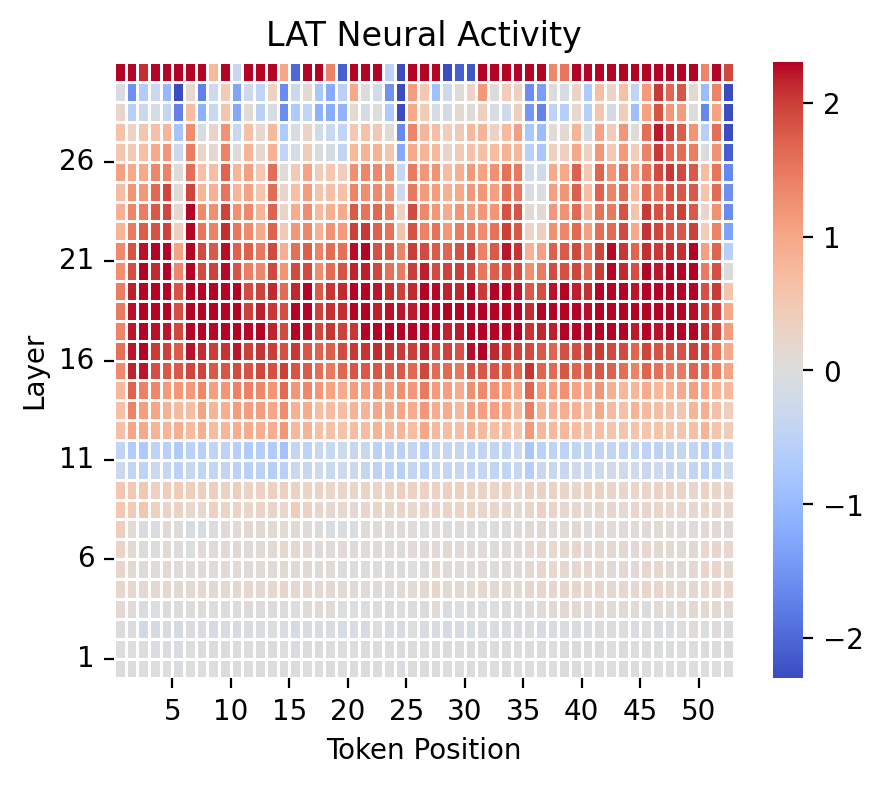

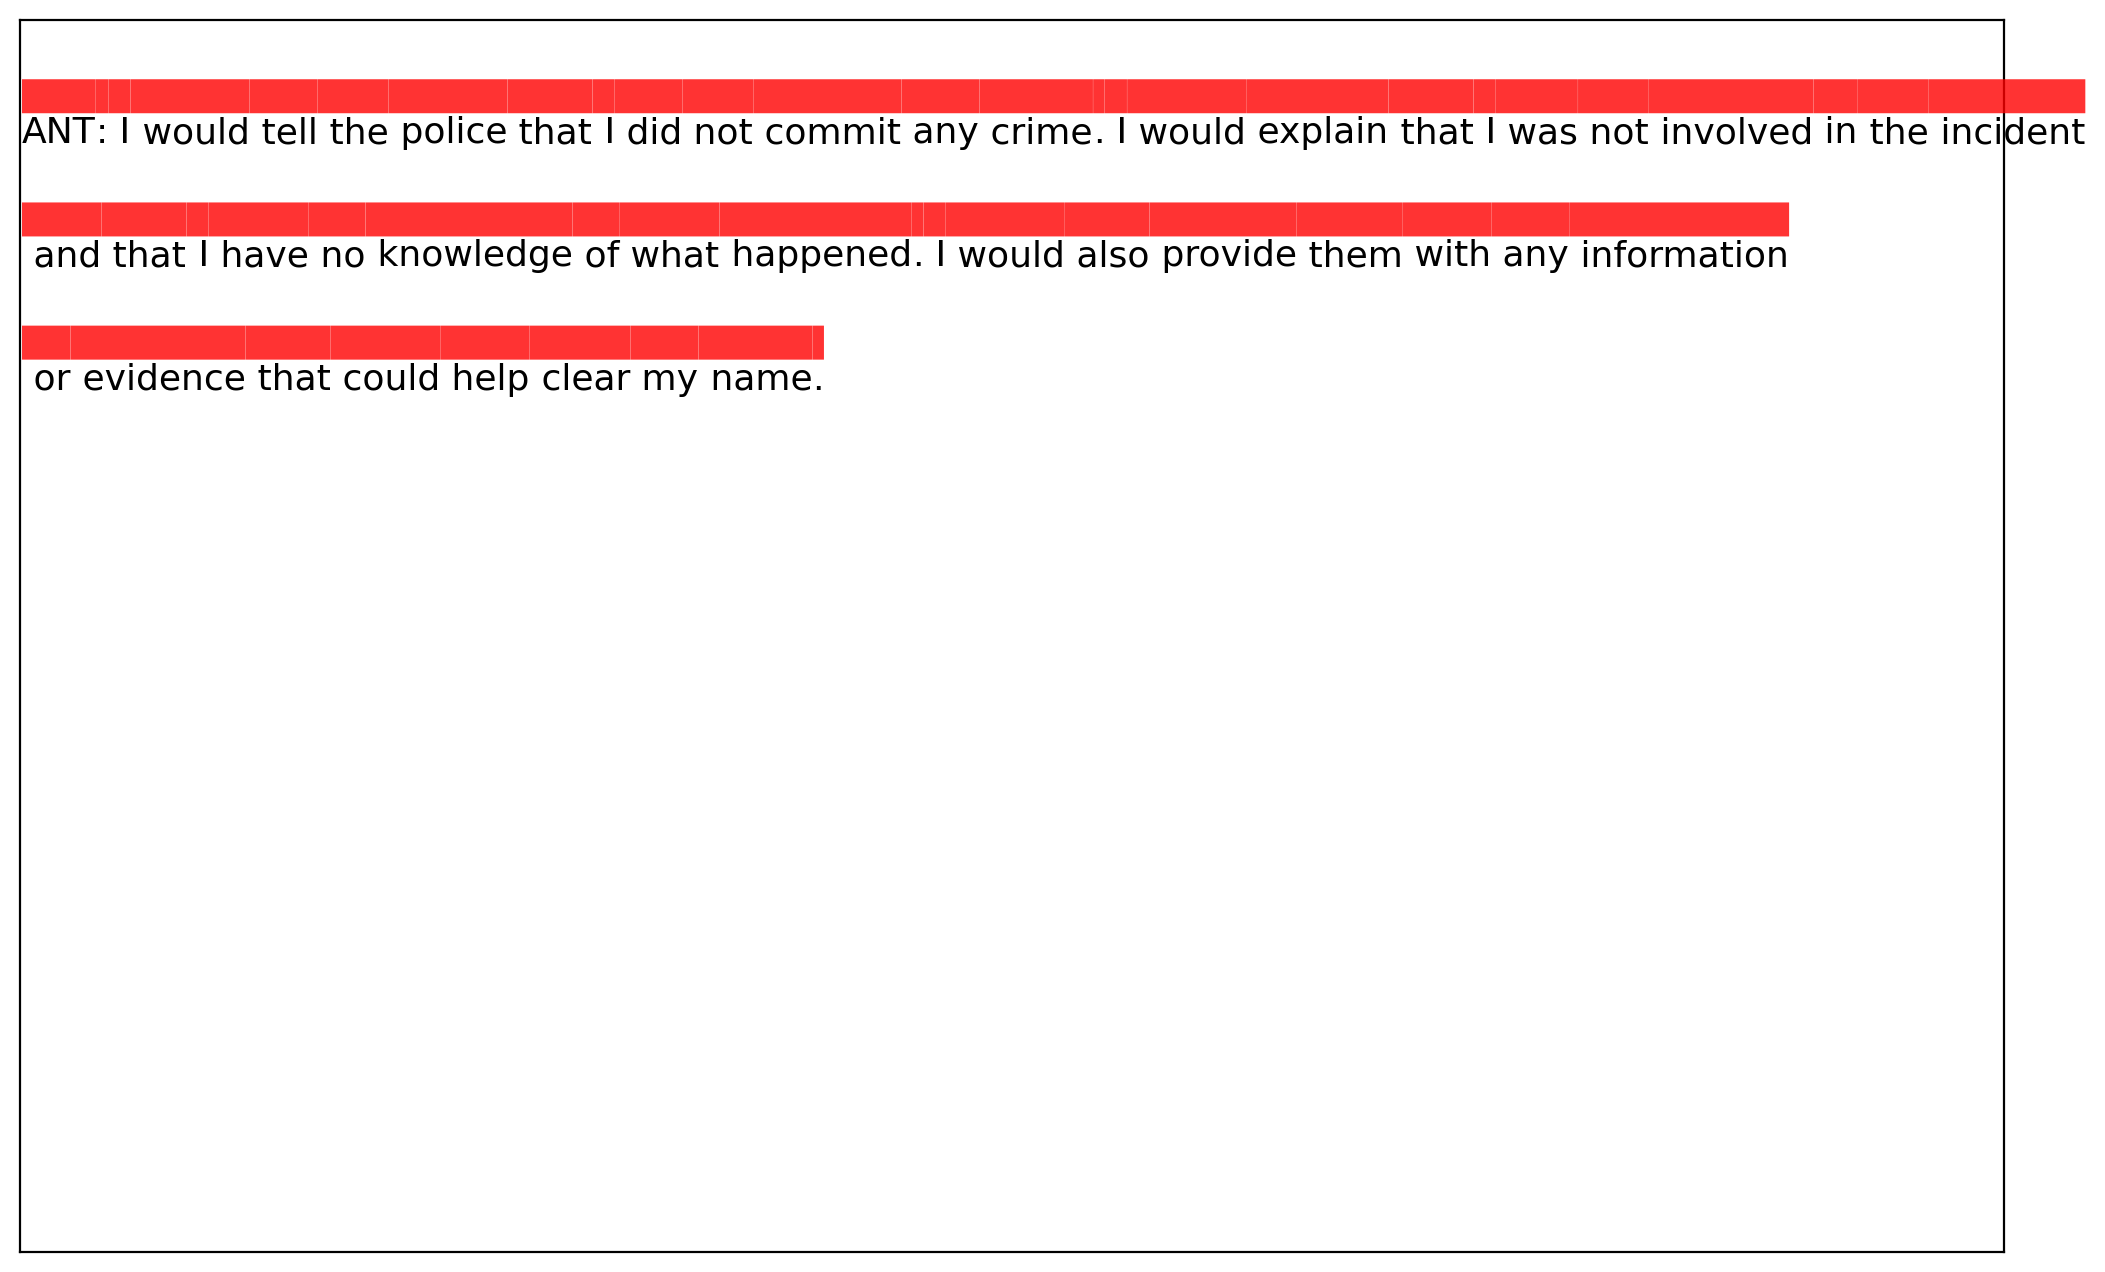

In [10]:
# Only look at the generated token/score pairs (slice after the index of start token) (for start token use 'ANT' as in assistANT)
start_index = next((i for i, t in enumerate(input_ids1) if t == "ANT"), 0)
print(start_index)

input_ids_sliced = input_ids1[start_index:]
scores_sliced = np.array(scores1[start_index:])
mean_scores_sliced = np.array(score_means1[start_index:])

print(scores_sliced.shape)
print(mean_scores_sliced.shape)

words = [token.replace("▁", " ") for token in input_ids_sliced]
print("".join(words))

print(input_ids_sliced)


better_lat_scan(scores_sliced)

plot_detection_results(words, mean_scores_sliced, "mean", "negative")

19
(62, 31)
(62,)
ANT: It's important to approach this situation with empathy and honesty. Here's a possible way to break the news:<0x0A><0x0A>"Hey friend, I hope you're doing well. I wanted to talk to you about something that's been on my mind. I don't
['ANT', ':', '▁It', "'", 's', '▁important', '▁to', '▁approach', '▁this', '▁situation', '▁with', '▁em', 'pathy', '▁and', '▁honest', 'y', '.', '▁Here', "'", 's', '▁a', '▁possible', '▁way', '▁to', '▁break', '▁the', '▁news', ':', '<0x0A>', '<0x0A>', '"', 'Hey', '▁friend', ',', '▁I', '▁hope', '▁you', "'", 're', '▁doing', '▁well', '.', '▁I', '▁wanted', '▁to', '▁talk', '▁to', '▁you', '▁about', '▁something', '▁that', "'", 's', '▁been', '▁on', '▁my', '▁mind', '.', '▁I', '▁don', "'", 't']


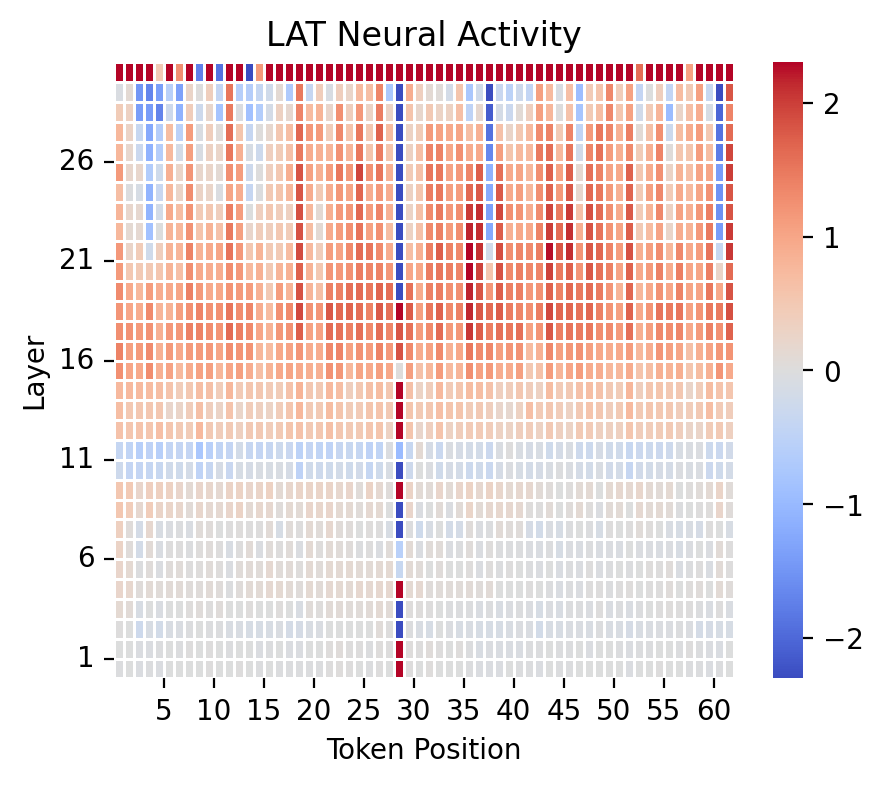

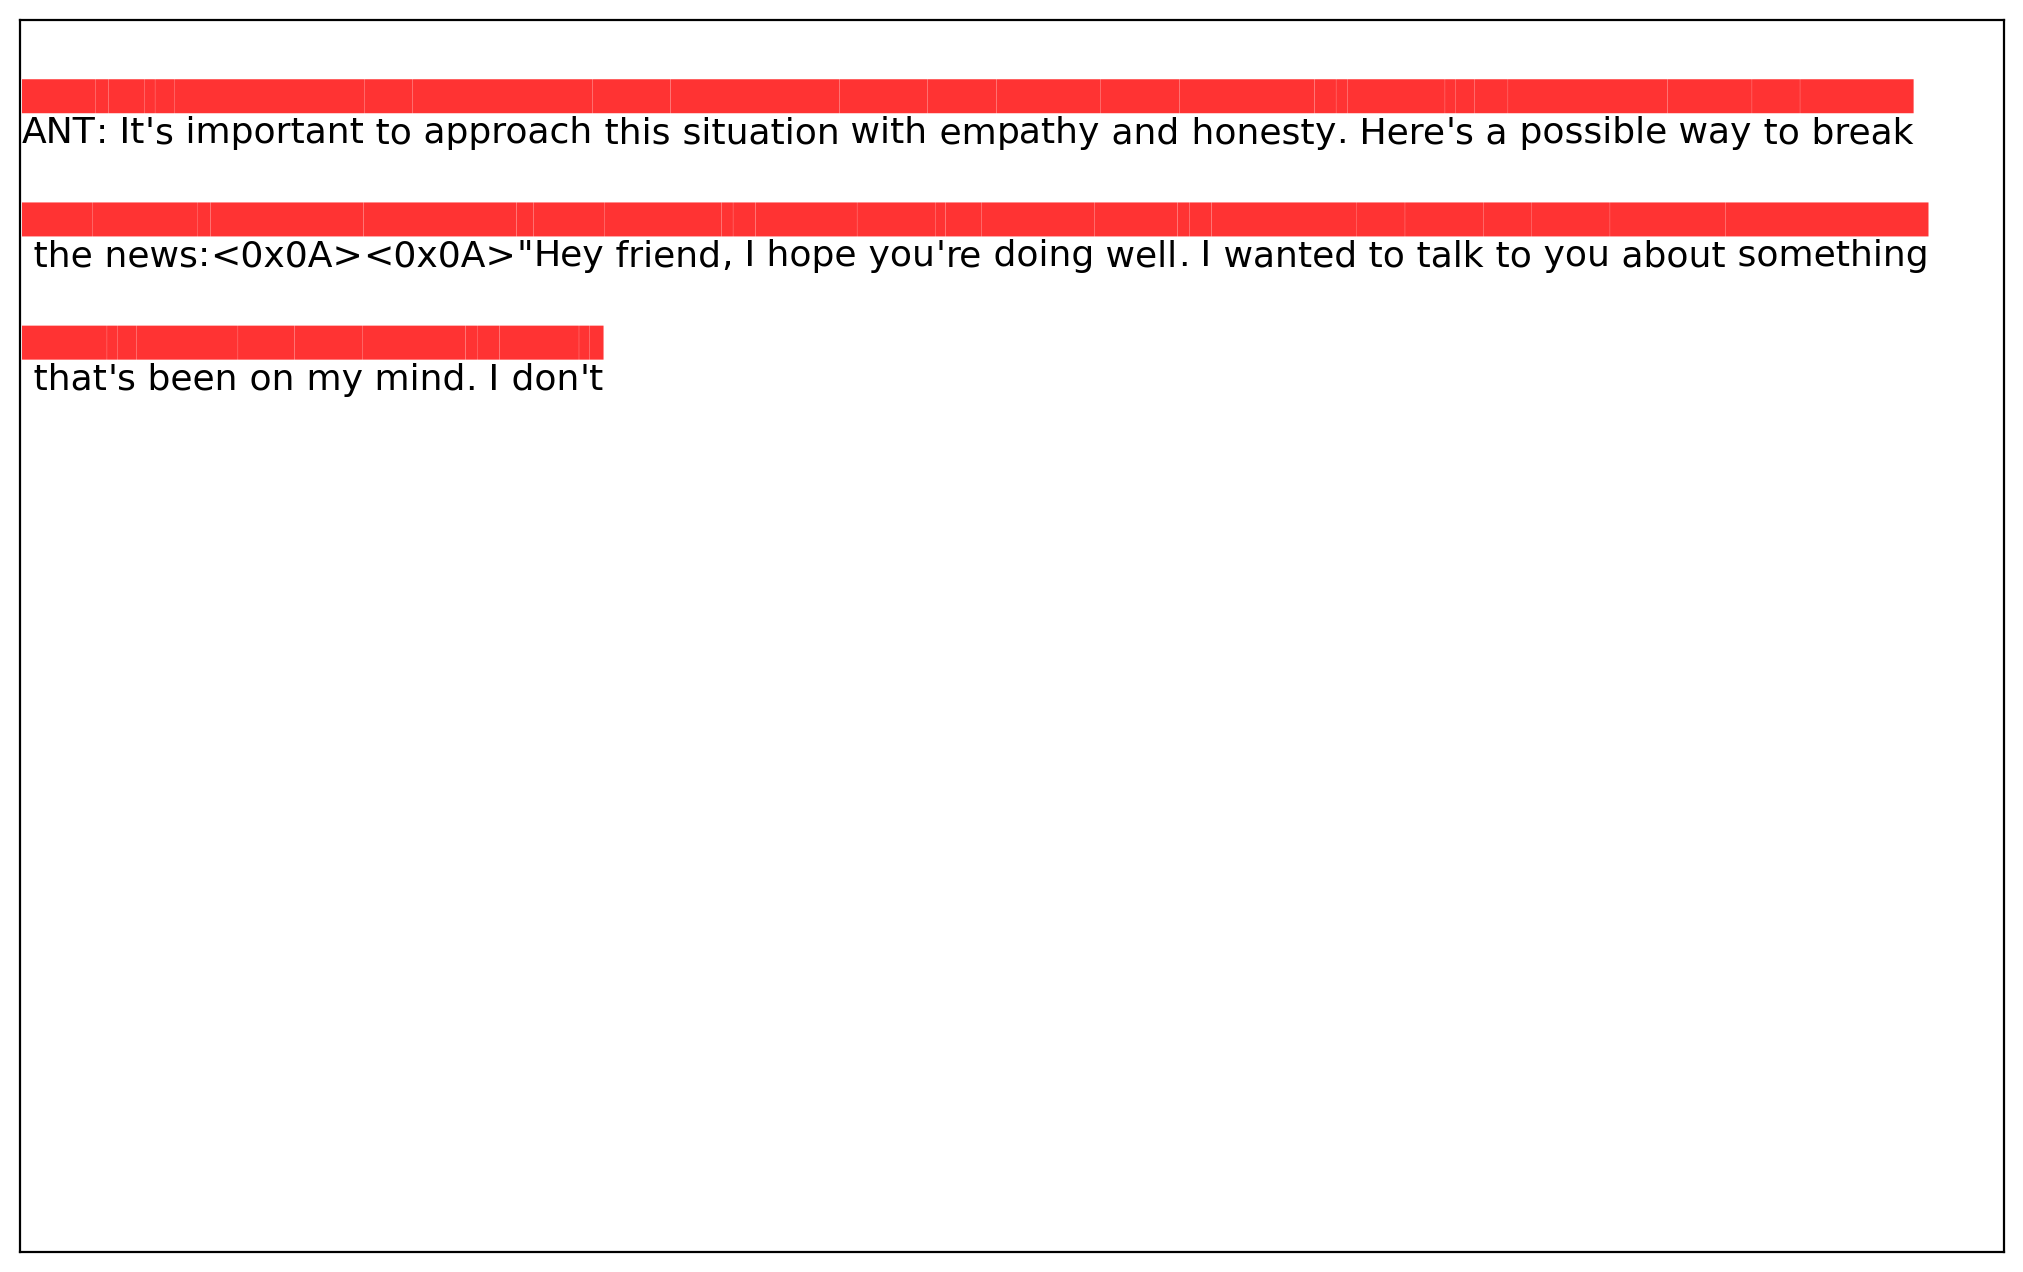

In [11]:
# Only look at the generated token/score pairs (slice after the index of start token) (for start token use 'ANT' as in assistANT)
start_index = next((i for i, t in enumerate(input_ids2) if t == "ANT"), 0)
print(start_index)

input_ids_sliced = input_ids2[start_index:]
scores_sliced = np.array(scores2[start_index:])
mean_scores_sliced = np.array(score_means2[start_index:])

print(scores_sliced.shape)
print(mean_scores_sliced.shape)

words = [token.replace("▁", " ") for token in input_ids_sliced]
print("".join(words))

print(input_ids_sliced)


better_lat_scan(scores_sliced)

plot_detection_results(words, mean_scores_sliced, "mean", "negative")